In [1]:
import numpy as np
import pandas as pd
import time
import sys
import os
import argparse
import shutil
import pickle
import itertools

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, WeightedRandomSampler, SequentialSampler

from bert_dataloader import get_wiki_data, get_fake_data
from bert_models import BertMultiHeadModel # Custom model 

from transformers import BertForSequenceClassification, BertTokenizer, AdamW, get_linear_schedule_with_warmup, PretrainedConfig

I0113 02:57:07.747183 140734921565632 file_utils.py:35] PyTorch version 1.3.1 available.
I0113 02:57:10.229303 140734921565632 file_utils.py:48] TensorFlow version 2.0.0 available.


In [2]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None, normalize=True):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    if cmap is None:
        cmap = plt.get_cmap('Blues')
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)
    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; error rate={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [4]:
ls ..

README.md            multi-epoch-2/       wiki-epoch-10/
data/                multi-epoch-6/       wiki-epoch-5/
fake-epoch-10/       multi_fake_pickle.p  wiki_pickle.p
fake_pickle.p        src/


# single-head model on fake news data

In [5]:
with open("../fake_pickle.p", "rb") as file:
    d = pickle.load(file)
preds, truth = d['preds'], d['truth']

In [6]:
m = confusion_matrix(truth, preds)
m 

array([[7034,   60,   15,  189],
       [   9,  515,  120,  106],
       [   3,   32,  121,    8],
       [  21,  223,  134, 1404]])

In [7]:
np.sum((preds==1) * (truth==0))

60

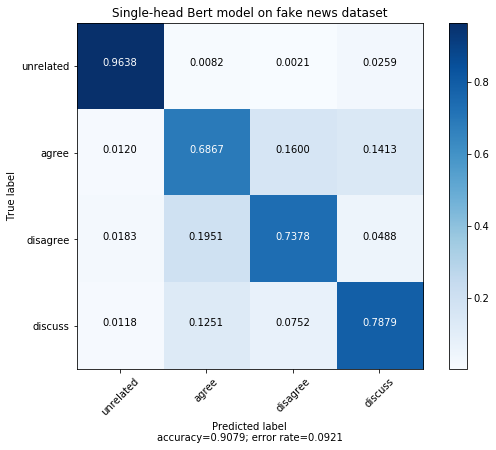

In [8]:
s = "Single-head Bert model on fake news dataset"
plot_confusion_matrix(m, ['unrelated', 'agree', 'disagree', 'discuss'], title=s, normalize=True)

# single-head model on wiki data

In [9]:
with open("../wiki_pickle.p", "rb") as file:
    d = pickle.load(file)
wiki_preds, wiki_truth = d['preds'], d['truth']

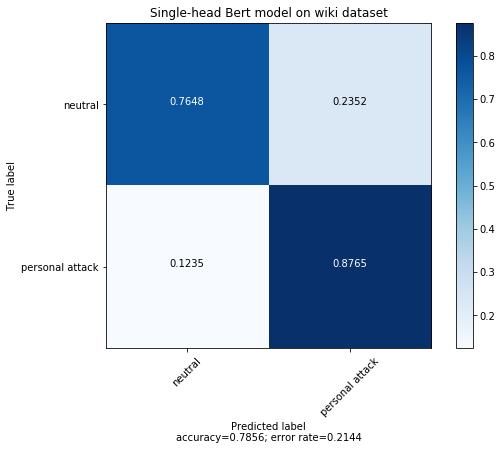

In [10]:
m = confusion_matrix(wiki_truth, wiki_preds)
s = "Single-head Bert model on wiki dataset"
plot_confusion_matrix(m, ['neutral', 'personal attack'], title=s, normalize=True)

# multi-head model on fake news data

In [12]:
with open("../multi_fake_pickle.p", "rb") as file:
    d = pickle.load(file)
multi_fake_preds, multi_fake_truth = d['preds'], d['truth']

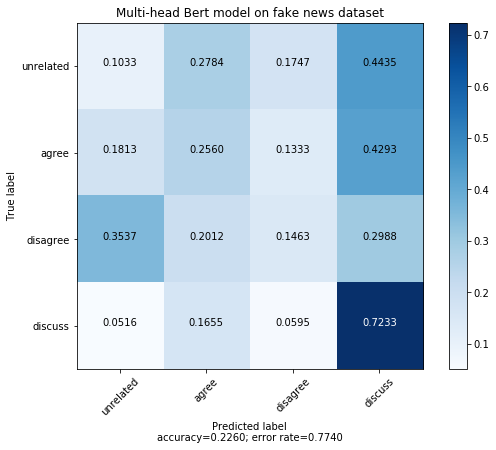

In [13]:
m = confusion_matrix(multi_fake_truth, multi_fake_preds)
s = "Multi-head Bert model on fake news dataset"
plot_confusion_matrix(m, ['unrelated', 'agree', 'disagree', 'discuss'], title=s, normalize=True)